# 1. Introduction

Ulasan pengguna di platform seperti Google Play Store telah menjadi sumber masukan yang sangat berharga bagi pengembang dalam mengevaluasi kualitas dan meningkatkan pengalaman pengguna sebuah aplikasi. Dengan basis pemain global yang sangat besar, Genshin Impact secara konsisten menerima berbagai macam ulasan yang mencerminkan kepuasan, harapan, hingga kritik dari komunitas pemainnya. Ulasan-ulasan ini tidak hanya berisi opini, tetapi juga menyimpan potensi insight yang kaya terhadap elemen-elemen penting dalam game, seperti desain karakter, mekanisme permainan, hingga narasi cerita.

Capstone project ini bertujuan untuk mengolah dan menganalisis ulasan pengguna Genshin Impact yang bersumber dari dataset publik Kaggle. Dengan bantuan model kecerdasan buatan IBM Granite, dilakukan proses analisis sentimen untuk mengidentifikasi persepsi pemain terhadap berbagai aspek permainan. Fokus utama analisis adalah mengeksplorasi area-area yang dipandang positif maupun negatif oleh pengguna, serta menyusun rekomendasi berbasis data yang dapat dimanfaatkan oleh pengembang dalam merancang perbaikan fitur dan peningkatan kualitas game.

Untuk mendukung analisis, dilakukan pula Exploratory Data Analysis (EDA) yang mencakup:

- Distribusi rating pengguna
- Identifikasi top 10 focus area yang paling sering disebutkan
- Korelasi antara rating dan sentimen
- Frekuensi kemunculan topik ulasan berdasarkan rating
- Kategori masalah utama yang paling banyak dikeluhkan (top problem categories)
- Analisis sentimen berdasarkan kata kunci (keyword-level sentiment analysis)

Diharapkan, hasil dari project ini dapat memberikan sudut pandang tambahan bagi pengembang Genshin Impact untuk lebih memahami preferensi dan keluhan pengguna secara objektif, sehingga dapat diambil langkah-langkah strategis dalam mengembangkan game yang semakin responsif terhadap kebutuhan pemain.

# 2. Setup

## 2.1 Install Setup

In [ ]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.8 MB/s eta 0:00:00


## 2.2 Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from wordcloud import WordCloud
from langchain_community.llms import Replicate
import os
from google.colab import userdata

## 2.3 Setup API

In [ ]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(
    model=model,
    replicate_api_token=api_token,
)

# 3. Data Load

In [ ]:
df = pd.read_csv('/content/genshin_review.csv')
df.head()

,review,rating
0,Absolute Masterpiece i hate the people who gav...,5
1,amazing but the fandom isn't amazing,5
2,Very nice,5
3,Give me gambling money (primo gems),4
4,"This is one my first Open World RPG games, and...",4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  995 non-null    object
 1   rating  995 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


In [ ]:
df.isnull().sum()

,0
review,0
rating,0


In [ ]:
df.duplicated().sum()

np.int64(47)

In [ ]:
df.drop_duplicates(inplace=True)

# 4. Data Preprocessing

In [ ]:
def clean_text(text):
    if pd.isnull(text):
        return ""

    # Hapus emoji
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emotikon
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transport & simbol lain
        u"\U0001F1E0-\U0001F1FF"  # bendera
        u"\U00002500-\U00002BEF"  # karakter Cina
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Hapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Hapus karakter non-alfabet (kecuali titik, koma, tanda seru, tanda tanya)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", '', text)

    # Hapus spasi ganda
    text = re.sub(r'\s+', ' ', text)

    # Strip spasi depan dan belakang
    text = text.strip()

    return text

Analisis dilakukan dengan hanya mengambil 50 sample dari dataset publik. Hal ini dilakukan karena terbatasnya API Token yang dimiliki

In [ ]:
sample_df = df.dropna().sample(n=50, random_state=42).reset_index(drop=True)

# Preprocessing teks
sample_df['review'] = sample_df['review'].apply(clean_text)

# 5. Model Interaction

## 5.1 Prompt

In [ ]:
def build_prompt(reviews):
  review_text = "\n".join([f"Review {i+1}: {text}" for i, text in enumerate(reviews)])
  prompt = f"""
  You are analyzing user reviews for the game Genshin Impact. For each review, extract the following information:
  1. Sentiment: (positive, negative, or neutral). If there is positive and negative sentiment, then it is entered as neutral
  2. Focus Areas: such as gameplay, characters, storyline, fanbase, bugs, gacha system, etc.
  3. Keywords: list important keywords or repeated terms from the review
  4. Problem Category (if applicable): categorize any player complaints like 'bug', 'gacha', 'performance', 'content', or 'character balance'
  5. Summary: generate a short and concise summary of the review

  Reviews:
  {review_text}

  Please return the results in this structured format per review:
  Review X:
  Sentiment: positive, negative, or neutral
  Focus Areas: ...
  Keywords: ...
  Problem Category: ...
  Summary: ...
  """
  return prompt


Prompt ini digunakan untuk memperintahkan model dalam menganalisis seniment, fokus area, keyword, problem category, dan summary dari dataset


## 5.2 Cleaning dan Parsing hasil granite


In [ ]:
# Bersihkan hasil sentiment
def clean_sentiment(sentiment_text):
    sentiment_text = sentiment_text.lower()
    if "positive" in sentiment_text:
        return "positive"
    elif "negative" in sentiment_text:
        return "negative"
    elif "neutral" in sentiment_text:
        return "neutral"
    else:
        return "neutral"

In [ ]:
# Parsing hasil Granite
def parse_response(response_text):
    parsed = {
        "sentiment": None,
        "focus_areas": None,
        "keywords": None,
        "problem_category": None,
        "summary": None
    }

    sentiment = re.search(r"Sentiment:\s*(.*)", response_text, re.IGNORECASE)
    if sentiment: parsed["sentiment"] = clean_sentiment(sentiment.group(1))

    focus = re.search(r"Focus Areas:\s*(.*)", response_text, re.IGNORECASE)
    if focus: parsed["focus_areas"] = focus.group(1).strip()

    keywords = re.search(r"Keywords:\s*(.*)", response_text, re.IGNORECASE)
    if keywords: parsed["keywords"] = keywords.group(1).strip()

    problem = re.search(r"Problem Category:\s*(.*)", response_text, re.IGNORECASE)
    if problem: parsed["problem_category"] = problem.group(1).strip()

    summary = re.search(r"Summary:\s*(.*)", response_text, re.IGNORECASE)
    if summary: parsed["summary"] = summary.group(1).strip()

    return parsed

## 5.3 Inference

In [ ]:
# Inference dengan batching
def batch_inference(df, llm, batch_size=5, delay=3):
    results = []
    for i in range(0, len(df), batch_size):
        batch = df['review'].iloc[i:i+batch_size].tolist()
        prompt = build_prompt(batch)
        try:
            print(f"⏳ Processing batch {i} to {i+len(batch)}...")
            response = llm.invoke(prompt)
            lines = [line for line in response.strip().split('\n') if line.strip()]
            batch_blocks = response.split("Review")
            for block in batch_blocks:
                if block.strip():
                    parsed = parse_response(block)
                    results.append(parsed)
        except Exception as e:
            print(f"[!] Error on batch {i}:", e)
            for _ in range(len(batch)):
                results.append({
                    "sentiment": "neutral",
                    "focus_areas": "error",
                    "keywords": "error",
                    "problem_category": "error",
                    "summary": "error"
                })
        time.sleep(delay)
    return results


In [ ]:
result_rows = sample_df[['review']].dropna().copy()
print(f"🔍 Total review yang akan diproses: {len(sample_df)}")

# Analisis
result_rows = batch_inference(sample_df, llm, batch_size=10, delay=3)

# Gabungkan hasil
sample_df = sample_df.reset_index(drop=True)
sample_result = pd.concat([sample_df, pd.DataFrame(result_rows)], axis=1)

# Simpan
sample_result.to_csv("full_analysis_reviews.csv", index=False)
print("✅ Analisis selesai. Data disimpan ke 'full_analysis_reviews.csv'")

🔍 Total review yang akan diproses: 50
⏳ Processing batch 0 to 10...
⏳ Processing batch 10 to 20...
⏳ Processing batch 20 to 30...
⏳ Processing batch 30 to 40...
⏳ Processing batch 40 to 50...
✅ Analisis selesai. Data disimpan ke 'full_analysis_reviews.csv'


In [ ]:
sample_result.head()

,review,rating,sentiment,focus_areas,keywords,problem_category,summary
0,you cant play with your friends because your t...,1,negative,gameplay,"task completion, friends play",gameplay,The reviewer expresses frustration with the in...
1,This game is good everything.What I would like...,4,positive,"accessibility, localization","languages, good",N/A,The reviewer praises the game overall and sugg...
2,Awesome game,5,positive,overall game,"awesome, game",N/A,The reviewer conveys a positive sentiment with...
3,This games storage is ridiculous. 30GB on mobi...,5,negative,"storage, mobile version","storage, 30GB, mobile",performance,The reviewer criticizes the game's large stora...
4,Majaa game ehh,4,neutral,overall game,"Majaa, game",N/A,The reviewer provides a neutral sentiment with...


# 6. EDA

### 6.1 Distribusi Rating

<ipython-input-18-3b08e2d9b731>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', palette='crest')


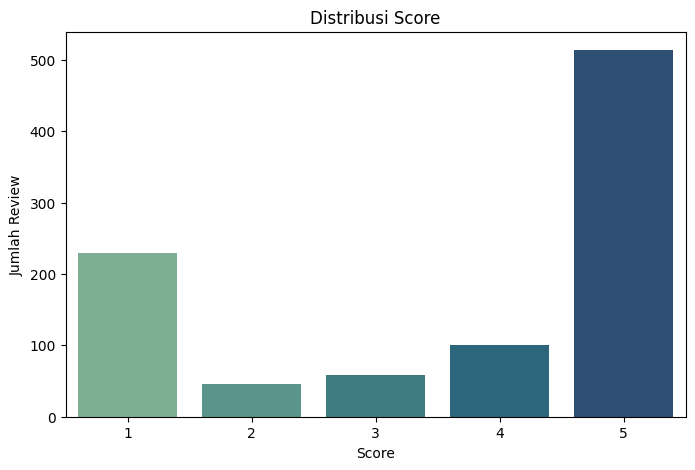

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='rating', palette='crest')
plt.title('Distribusi Score')
plt.xlabel('Score')
plt.ylabel('Jumlah Review')
save
plt.show()

## 6.2 DIstribusi Sentimen

In [ ]:
sample_result_clean = sample_result.dropna(subset=['sentiment', 'focus_areas']).copy()

<ipython-input-20-ef26c16bd054>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sample_result, x='sentiment', palette='Set2')


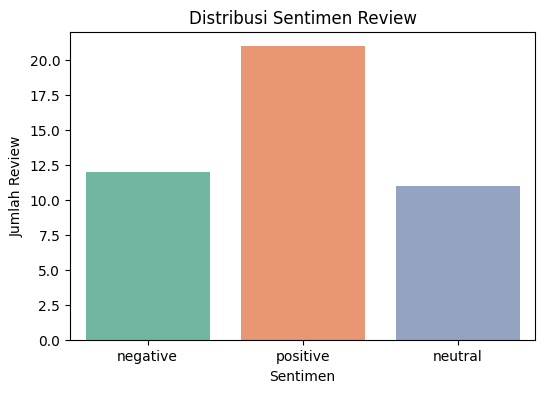

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=sample_result, x='sentiment', palette='Set2')
plt.title("Distribusi Sentimen Review")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

Visualisasi di atas menunjukkan bahwa mayoritas ulasan pengguna terhadap Genshin Impact bersentimen positif. Sentimen negatif berada di posisi kedua, diikuti oleh sentimen netral sebagai yang paling sedikit. Hal ini mengindikasikan bahwa secara umum pemain memiliki persepsi yang cukup baik terhadap permainan ini, meskipun masih terdapat sejumlah kritik yang perlu diperhatikan.

## 6.3 Top Focus Areas

In [ ]:
sample_result_clean['focus_areas'] = sample_result_clean['focus_areas'].apply(
    lambda x: [tag.strip().lower() for tag in x.split(',') if tag.strip()]
)

In [ ]:
focus_exploded = sample_result_clean.explode('focus_areas')

# Hapus baris dengan focus_areas kosong setelah explode
focus_exploded = focus_exploded[focus_exploded['focus_areas'].str.strip() != '']
focus_exploded = focus_exploded.dropna(subset=['focus_areas'])

focus_exploded = focus_exploded[focus_exploded['focus_areas'].str.lower() != 'n/a']
focus_exploded = focus_exploded[focus_exploded['focus_areas'].str.lower() != 'na']

focus_rating_counts = focus_exploded.groupby(['sentiment', 'focus_areas']).size().reset_index(name='count')
total_focus_counts = focus_exploded['focus_areas'].value_counts().reset_index()
total_focus_counts.columns = ['focus_areas', 'total_count']

focus_rating_counts = pd.merge(focus_rating_counts, total_focus_counts, on='focus_areas')


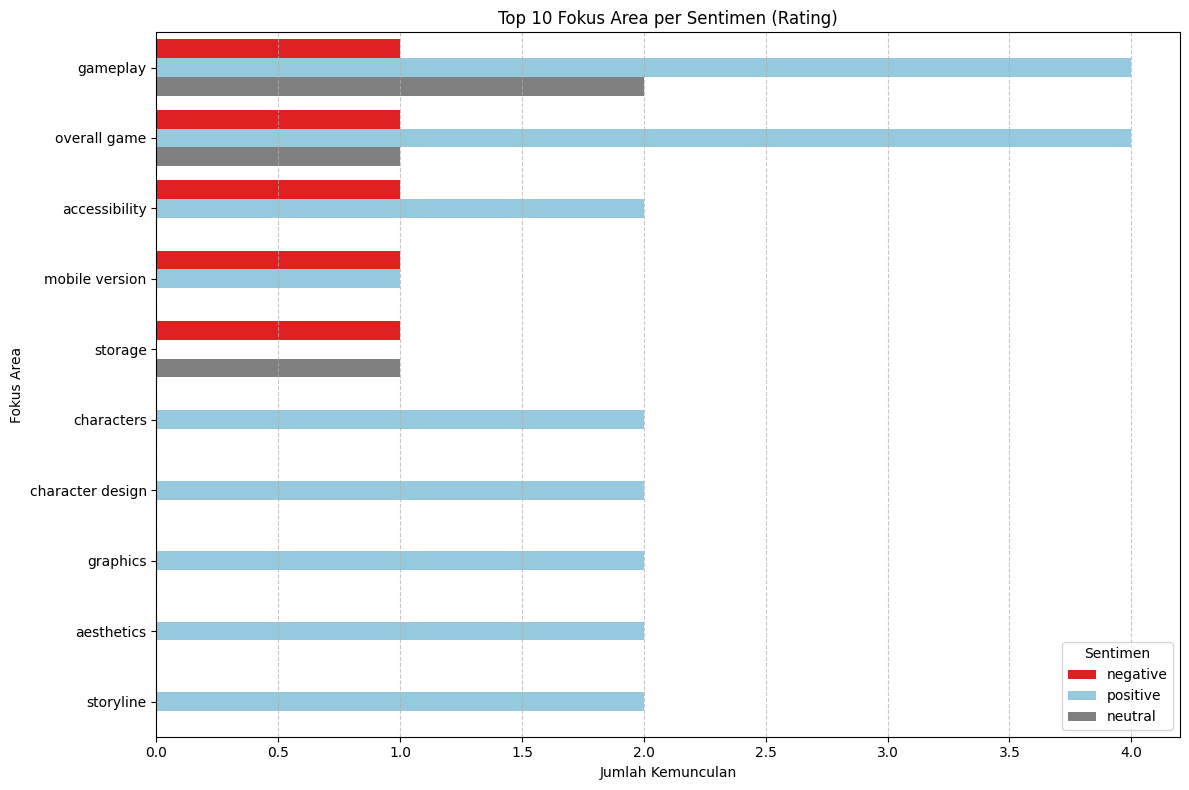

In [ ]:
top_n = 10 # Anda bisa ubah angka ini
top_focus_areas = total_focus_counts.head(top_n)['focus_areas'].tolist()

# Filter DataFrame hanya untuk top focus areas
focus_rating_counts_top = focus_rating_counts[focus_rating_counts['focus_areas'].isin(top_focus_areas)].copy()

# Urutkan berdasarkan total_count untuk mempertahankan urutan di plot
focus_rating_counts_top['focus_areas'] = pd.Categorical(
    focus_rating_counts_top['focus_areas'],
    categories=top_focus_areas,
    ordered=True
)
focus_rating_counts_top = focus_rating_counts_top.sort_values('focus_areas')

#Visualisasi
plt.figure(figsize=(12, 8))
sns.barplot(
    data=focus_rating_counts_top,
    x='count',
    y='focus_areas',
    hue='sentiment',
    palette=['red', 'skyblue', 'gray'],
    orient='h' # Horizontal bar plot
)

plt.title(f"Top {top_n} Fokus Area per Sentimen (Rating)")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Fokus Area")
plt.legend(title="Sentimen")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Visualisasi ini mengidentifikasi sepuluh fokus utama yang sering muncul dalam ulasan pengguna berdasarkan sentimen. Area seperti gameplay, overall game, accessibility, mobile version, dan storage mendapat berbagai respon, mulai dari positif hingga negatif.

Kehadiran sentimen negatif pada beberapa aspek-aspek tersebut menunjukkan adanya peluang perbaikan, sementara dominasi sentimen positif pada elemen seperti character design, graphics, dan storyline menegaskan kekuatan utama dari game Genshin Impact.

## 6.4 Top Problem category

<ipython-input-30-6319abd11618>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_problems.values, y=top_problems.index, palette='viridis')


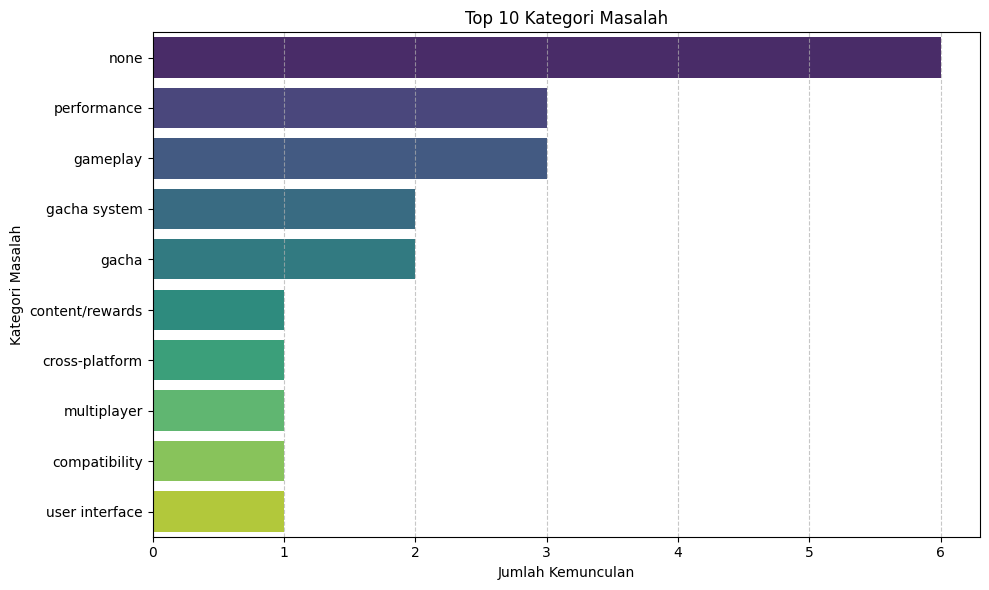

In [ ]:
# Ganti 'n/a', 'na', 'N/A', 'NA', None, '(none)' dengan NaN, lalu hapus baris dengan NaN di kolom problem_category
problem_df = sample_result_clean.copy()
problem_df['problem_category'] = problem_df['problem_category'].replace(['n/a', 'na', 'N/A', 'NA', 'none', '(none)'], pd.NA)
problem_df = problem_df.dropna(subset=['problem_category'])

# Split string problem_category jika ada multiple categories dipisahkan koma
problem_df['problem_category'] = problem_df['problem_category'].str.split(',')
problem_exploded = problem_df.explode('problem_category')
problem_exploded['problem_category'] = problem_exploded['problem_category'].str.strip().str.lower()

# Hapus lagi jika ada nilai kosong setelah split dan strip
problem_exploded = problem_exploded[problem_exploded['problem_category'] != '']

# Hitung Frekuensi
problem_counts = problem_exploded['problem_category'].value_counts()

# Pilih Top N
top_n_problems = 10
top_problems = problem_counts.head(top_n_problems)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=top_problems.values, y=top_problems.index, palette='viridis')
plt.title(f"Top {top_n_problems} Kategori Masalah")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Kategori Masalah")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6.5 Distribusi Sentimen Setiap Rating

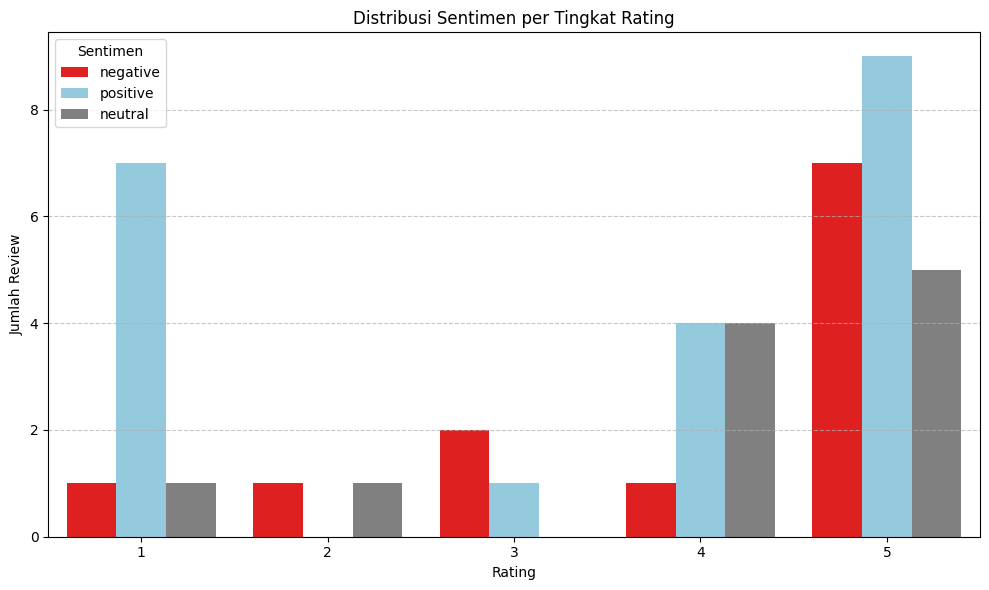

In [ ]:
# Urutkan rating agar tampil berurutan di plot
sample_result['rating'] = sample_result['rating'].astype(int)
sample_result_sorted = sample_result.sort_values('rating')

plt.figure(figsize=(10, 6))
sns.countplot(data=sample_result_sorted, x='rating', hue='sentiment', palette=['red', 'skyblue', 'gray']) # Menggunakan palette yang sudah disesuaikan
plt.title("Distribusi Sentimen per Tingkat Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.legend(title="Sentimen")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6.6 Top Keyword

### 6.6.1 Top Keyword General

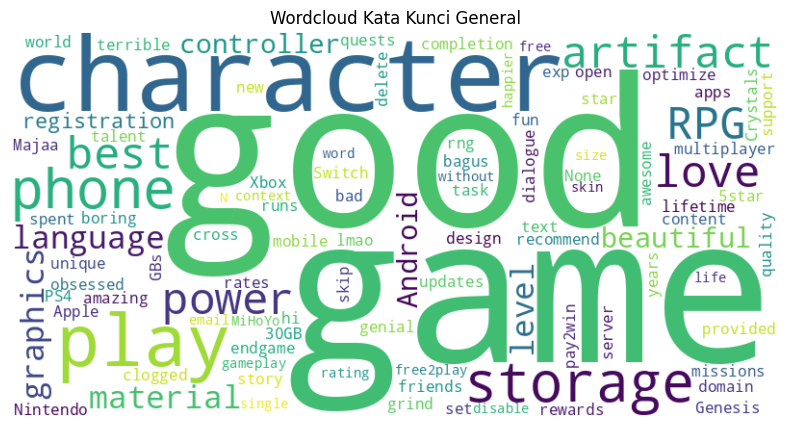

In [ ]:
# Combine keywords from all reviews
all_keywords = ' '.join(sample_result_clean['keywords'].dropna().astype(str))

# Generate Wordcloud
wordcloud_general = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Visualize
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_general, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Kata Kunci General')
plt.show()

Wordcloud ini menampilkan kata kunci yang paling sering muncul dalam ulasan pemain Genshin Impact di Google Play Store. Kata seperti “good”, “game”, dan “character” mendominasi, yang menunjukkan bahwa pemain sering menyoroti kualitas permainan dan desain karakter sebagai aspek utama. Kata kunci lain seperti “storage”, “phone”, dan “artifact” juga muncul cukup signifikan, mengindikasikan adanya perhatian atau keluhan terhadap performa teknis dan mekanisme tertentu dalam game.

### 6.6.2 Top Keyword Positif

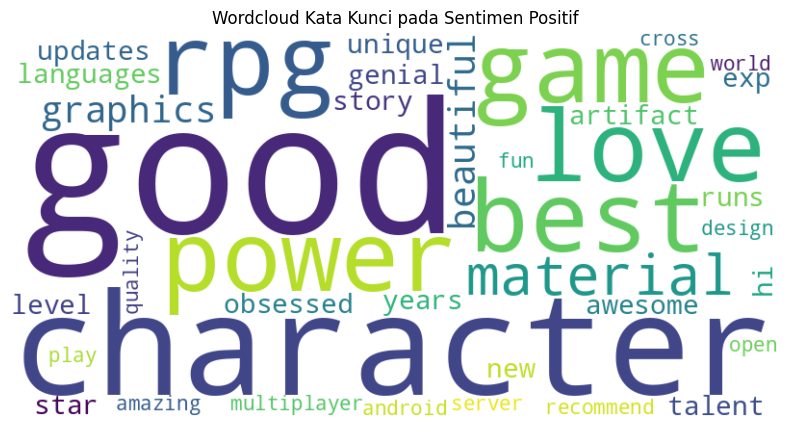

In [ ]:
positive_reviews = sample_result_clean[sample_result_clean['sentiment'] == 'positive'].copy()

positive_reviews['keywords'] = positive_reviews['keywords'].fillna('').astype(str)
all_positive_keywords = ' '.join(positive_reviews['keywords'])

all_positive_keywords = all_positive_keywords.lower()

if all_positive_keywords:
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(all_positive_keywords)

    # Visualisasi
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud Kata Kunci pada Sentimen Positif')
    plt.show()
else:
    print("Tidak ada kata kunci yang ditemukan pada review dengan sentimen positif.")

Visualisasi ini menggambarkan kata kunci yang paling sering muncul dalam ulasan dengan sentimen positif. Kata “good”, “character”, dan “game” muncul sebagai kata dominan, yang mencerminkan kepuasan pemain terhadap kualitas permainan dan desain karakter. Kata lain seperti “love”, “best”, dan “rpg” turut memperkuat kesan bahwa pengalaman bermain Genshin Impact dinilai sangat positif oleh sebagian besar pemain.

### 6.6.3 Keyword Negatif

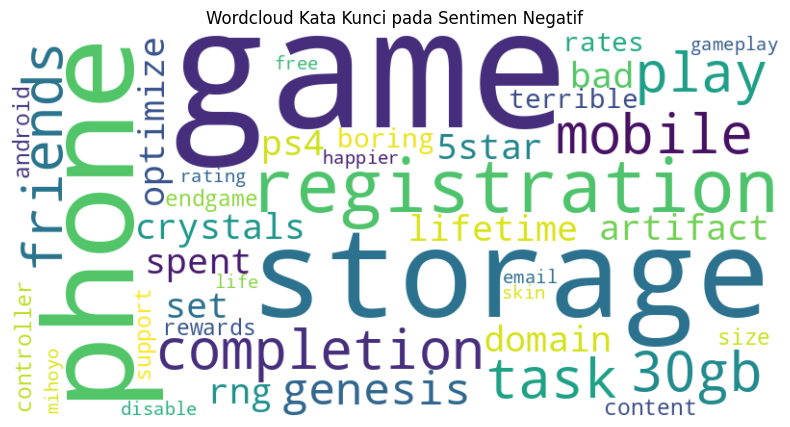

In [ ]:
negative_reviews = sample_result_clean[sample_result_clean['sentiment'] == 'negative'].copy()

negative_reviews['keywords'] = negative_reviews['keywords'].fillna('').astype(str)
all_negative_keywords = ' '.join(negative_reviews['keywords'])

all_negative_keywords = all_negative_keywords.lower()

if all_negative_keywords:
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(all_negative_keywords)

    # Visualisasi
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud Kata Kunci pada Sentimen Negatif')
    plt.show()
else:
    print("Tidak ada kata kunci yang ditemukan pada review dengan sentimen negatif.")

Wordcloud ini mengidentifikasi kata kunci yang paling sering muncul dalam ulasan dengan sentimen negatif. Kata seperti “game”, “phone”, dan “storage” mendominasi, mengindikasikan bahwa masalah terkait performa permainan, kebutuhan ruang penyimpanan yang besar, dan pengalaman bermain di perangkat mobile menjadi sumber utama keluhan pengguna. Kata lain seperti “registration”, “task”, dan “completion” juga muncul, menunjukkan potensi masalah dalam proses login atau mekanisme misi dalam game.

# 7. Recommendations

Berdasarkan keseluruhan hasil Exploratory Data Analysis (EDA) terhadap ulasan pengguna Genshin Impact di Google Play, berikut adalah rekomendasi strategis yang dapat dilakukan oleh developer untuk meningkatkan kualitas dan kepuasan pengguna:

1. **Optimasi Performa & Penggunaan Storage** <br>
Problem: Berdasarkan keyword "**Storage**", "**30GB**", "**Phone**", "**Mobile**" mendominasi sentimen negatif <br>
Rekomendasi: Developer perlu melakukan optimasi ukuran aplikasi, terutama pada versi mobile. Pertimbangkan penggunaan kompresi data atau modularisasi konten agar pengguna hanya mengunduh konten yang diperlukan.

2. **Perbaiki Sistem Registrasi dan Login** <br>
Problem: Berdasarkan keyword "**registration**", "**completion**", dan "**task**" sering muncul pada sentimen negatif. <br>
Rekomendasi: Developer perlu tinjau ulang UX/UI pada proses pendaftaran dan misi dalam game. Pastikan sistem tidak membingungkan, serta berikan panduan yang jelas agar onboarding player lebih mulus.

3. **Tingkatkan Kualitas dan Inovasi Gameplay**
insight: Keyword good, character, graphics, dan RPG mendominasi ulasan positif. <br>
Rekomendasi: Developer perlu mempertahankan dan terus kembangkan kualitas karakter dan desain permainan. Tambahkan konten baru secara berkala untuk menjaga antusiasme pemain lama dan menarik pemain baru.

4. **Tingkatkan Aksesibilitas dan Kompatibilitas** <br>
Problem: Fokus area seperti "mobile version" dan "accessibility" muncul dalam sentimen netral dan negatif. <br>
Rekomendasi: Developer perlu meningkatkan kompatibilitas game di berbagai perangkat, terutama mid-to-low-end smartphone. Pastikan semua fitur bisa diakses dengan baik oleh semua tipe pengguna.

5. **Kembangkan Gameplay dan Keseluruhan Konten Game**<br>
Insight: fokus area menunjukkan kebutuhan terhadap pengembangan overall game dan gameplay. <br>
Rekomendasi: Developer perlu rutin melakukan analisis ulasan untuk memahami kebutuhan pemain secara dinamis dan mengimplementasikan perubahan berbasis data, bukan asumsi.










# 8. Conclusion

Berdasarkan hasil eksplorasi data analitik terhadap ulasan pengguna Genshin Impact di Google Play Store, dapat disimpulkan bahwa mayoritas pengguna memberikan ulasan dengan sentimen positif. Hal ini menunjukkan bahwa secara umum pemain merasa puas terhadap kualitas permainan, khususnya pada aspek karakter, grafis, dan pengalaman bermain (gameplay). Namun demikian, ulasan dengan sentimen negatif juga mengungkap sejumlah isu penting yang perlu mendapat perhatian, seperti ukuran file game yang besar, proses registrasi yang membingungkan, serta performa aplikasi pada perangkat mobile. Temuan ini diperkuat melalui analisis fokus area dan wordcloud kata kunci, yang menunjukkan bahwa aspek seperti gameplay, aksesibilitas, dan versi mobile merupakan area yang paling banyak disoroti oleh pengguna. Kata kunci seperti “storage”, “registration”, dan “phone” muncul dominan pada ulasan negatif, sedangkan kata seperti “good”, “game”, dan “character” mendominasi pada ulasan positif. Berdasarkan temuan tersebut, beberapa rekomendasi dapat diberikan kepada developer, antara lain melakukan optimasi ukuran aplikasi khususnya untuk pengguna mobile, menyederhanakan proses registrasi dan penyelesaian misi, serta meningkatkan kompatibilitas lintas perangkat.

Dengan pendekatan berbasis data ini, developer Genshin Impact dapat lebih memahami kebutuhan dan keluhan pengguna secara menyeluruh, sehingga pengambilan keputusan dalam pengembangan produk menjadi lebih terarah, efektif, dan berfokus pada kepuasan pemain.